<a href="https://colab.research.google.com/github/umbertogagl97/Tesi/blob/main/Impronte/AttaccoScanner/Attacco_scanner_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Init**

##Import ART

In [6]:
#importa ART
!pip install adversarial-robustness-toolbox

## Import librerie

In [7]:
#Librerie

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
#import time
#import os
#import shutil
#import copy

import pandas as pd
import matplotlib.pyplot as plt
import sys

import cv2
from google.colab.patches import cv2_imshow


##Check device


In [8]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.9.0+cu111
True
Tesla P100-PCIE-16GB
cuda:0


##Def path

In [9]:
#scanner
scanner_name = 'HiScan'

#salvataggio modello
model_name = 'VGG19_paper_10epoc_lr5_bs200_adam'
path_model = F"/content/gdrive/My Drive/ModelliCNN/Scanner/{scanner_name}/{model_name}" 

#dataset
pathTestset=F'/content/gdrive/MyDrive/Dataset_impronte/test/{scanner_name}'

##Collegamento google drive

In [10]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#**Dataset**

##Caricamento dataset

In [38]:
test_dataset = datasets.ImageFolder(pathTestset,transforms.ToTensor())
dim_set=len(test_dataset)
print(dim_set)

2500


##riduzione dataset

In [12]:
test_dataset.samples=test_dataset.samples[:50]
test_dataset.targets=test_dataset.targets[:50]

dim_set=len(test_dataset)
print(dim_set)

50


##Dataloader

In [39]:
testgen=torch.utils.data.DataLoader(test_dataset, pin_memory=True, batch_size=1,num_workers=2)
print(len(testgen))

2500


##Nomi classi

In [40]:
classes_name=test_dataset.classes
class_number=len(classes_name)
print(classes_name)
print(class_number)

['Live', 'Spoof']
2


#**Dataset attack**

##Caricamento dataset

In [41]:
data_transform=data_transform=transforms.Compose([transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
test_dataset_at = datasets.ImageFolder(pathTestset,transform=data_transform)
dim_set_at=len(test_dataset_at)
print(dim_set_at)

2500


##riduzione dataset

In [16]:
test_dataset_at.samples=test_dataset_at.samples[:50]
test_dataset_at.targets=test_dataset_at.targets[:50]

dim_set=len(test_dataset_at)
print(dim_set)

50


##Dataloader

In [42]:
testgen_at=torch.utils.data.DataLoader(test_dataset_at, pin_memory=True, batch_size=1,num_workers=2)
print(len(testgen_at))

2500


# **Creazione modello**

> non ho bloccato i parametri inferiori e sbloccato quelli del classificatore, vedi se funziona



##Load model pre-trained

In [43]:
model = models.vgg19(pretrained=True,progress=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

##Aggiunta classificatore

In [44]:
model.classifier[6]=nn.Linear(4096,2) #per vgg19
#model.classifier=nn.Linear(1920,2) #per densenet201

print(model) 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

##Load pesi

In [45]:
model.load_state_dict(torch.load(path_model))#,map_location=torch.device('cpu')))


<All keys matched successfully>

##Set iperparametri

In [46]:
learning_rate = 1e-5

criterion = nn.CrossEntropyLoss() #criterio dell'aggiornamento del gradiente: minimizzazione funzione loss entropia
optimizer = optim.Adam(model.classifier.parameters(),lr=learning_rate)#,momentum=momentum)

# **Def funzioni**

##calcolo dim crop 

In [47]:
def calc_size(n):
  return tuple(int(np.ceil(i * (80/100))) for i in n)

##Calcolo perturbazioni



In [48]:
def compute_perturb(x,x_adv):
  '''
    x: img originali
    x_adv: img contraddittorie
    return: pertubazioni, media, perturbazioni normalizzate in [0,1] 
  '''
  perturb=x_adv-x
  m=np.mean(np.abs((x_adv - x)))
  print('Average perturbation: {:4.2f}'.format(m))
  min, max = np.amin(perturb), np.amax(perturb)
  perturb_norm = (perturb - min) / (max - min)
  return perturb,m,perturb_norm

##Testing

In [49]:
def testing(x,y,classifier):
  '''
    x: img test
    y: classi reali
    classifier: modello di tipo Keras addestrato
    return: valori probabilità, classi predette, accuracy
  '''
  
  value_preds=classifier.predict(x) #contiene i valori tra 0 e 1 predetti per ognuna delle 10 classi e per ogni immagine
  preds = np.argmax(value_preds, axis=1) #(le predizioni vanno da 0 a 9 e indicano la classe predetta)
  acc = (np.sum(preds == np.argmax(y, axis=1)) / y.shape[0])*100
  print("Accuracy on test set:", (round(acc,2)))
  #print("classi predette: ",preds)
  return value_preds,preds,acc

##Print subplot

In [50]:
def print_subplot(n_img,preds,value_preds_adv,x_test,y_test,x_test_adv,perturb_norm):
  '''
    n_img: prime n immagini da visualizzare
    preds: classi predette per img originali
    value_preds_adv: probabilità predette img contraddittorie
    x_test: img originali
    y_test: classi originali
    x_test_adv: img contraddittoria
    perturb_norm: perturbazioni normalizzate
  '''
  #nel seguente ciclo for si crea un vettore delle classi predette ordinato per probabilità decrescente
  for i in range(n_img):#(x_test.shape[0]):
    value=value_preds_adv[i]*100
    value_sorted=sorted(value,reverse=True)
    classes=[]
    for j in range(value.size) :
      ind=np.where(value==value_sorted[j]) #restituisce l'indice in value del valore uguale a value_sorted[i], quindi è la classe
      classes.append(ind[0][0]) #classes è il vettore finale
    
    value_sorted=[ round(elem, 2) for elem in value_sorted ]

    #in seguito per ogni immagine del test set si stampa un subplot
    fig = plt.figure(figsize=[10,10])
    plt.subplots_adjust(wspace=0.9)
    print('\033[1m'+"IMMAGINE "+'\033[1m',i) #valore END: '\033[0m'
    #originale
    ax1 = fig.add_subplot(131) #subplot con 3 righe e due colonne
    ax1.axis('off')
    #ax1.imshow(cv2.rotate(x_test[i],cv2.cv2.ROTATE_90_CLOCKWISE))
    ax1.imshow(x_test[i].transpose(1,2,0))
    ax1.title.set_text("ORIGINALE\nclasse reale: "+str(np.argmax(y_test[i]))+"\nclasse predetta: "+str(preds[i]))
    #perturbazione
    ax2 = fig.add_subplot(132)
    #ax2.imshow(cv2.rotate(perturb_norm[i],cv2.cv2.ROTATE_90_CLOCKWISE))
    ax2.imshow(perturb_norm[i].transpose(1,2,0))
    ax2.axis('off')
    ax2.title.set_text("PERTURBAZIONE")
    #perturbata
    ax3 = fig.add_subplot(133)
    #ax3.imshow(cv2.rotate(x_test_adv[i],cv2.cv2.ROTATE_90_CLOCKWISE))#,aspect='auto')
    ax3.imshow(x_test_adv[i].transpose(1,2,0))
    ax3.axis('off')
    ax3.title.set_text("PERTURBATA\nclassi predette: "+str(classes)+"\ncon valori: "+str(value_sorted))
    plt.show()

# **Esecuzione**

##creazione matrici

In [51]:
from art.utils import to_categorical
x_test=[]
y_test=[]
for input,label in testgen_at:
  #x_test.append(input.permute(0,2,3,1).numpy()[0,:,:,:])
  x_test.append(input.numpy()[0,:,:,:])
  y_test.append(to_categorical(label.numpy(),2)[0])

x_test=np.array(x_test)
y_test=np.array(y_test)

print(x_test.shape)
print(y_test.shape)

(2500, 3, 224, 224)
(2500, 2)


min max

In [52]:
min,max=np.min(x_test),np.max(x_test)
print(min,max)

-2.117904 2.64


Normalizza

In [180]:
x_test = (x_test - min) / (max - min)
min=0
max=1

##Creazione classificatore ART Pytorch



In [53]:
from art.estimators.classification import PyTorchClassifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min, max),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(224, 224, 3),
    nb_classes=class_number,
)

##Attacco

###Definizione attacco

In [54]:
from art.attacks.evasion import FastGradientMethod
# FGM
attack = FastGradientMethod(estimator=classifier,minimal=True, eps=0.5,eps_step=0.01)

###Generazione adversarial samples



In [55]:
x_test_adv = attack.generate(x=x_test,y=y_test) #aggiunge una perturbazione alle immagini del test set
#N.B. si possono passare le classi reali del test set (con y=y_test) e in questo caso FGM calcolerà le perturbazioni in modo che il classificatore
#non predica queste classi. Mentre, se non passo y_test, le calcolerà in modo da non fargli predire la classe predetta normalmente (la quale può essere diversa da quella reale
#se il classificatore non è corretto)

##Calcolo perturbazione

In [56]:
perturb,m,perturb_norm=compute_perturb(x_test,x_test_adv)

Average perturbation: 0.05


##Testing

> Trasforma i due testing in una funzione e richiamala due volte



###test img orig

In [57]:
Test = pd.DataFrame()
model.eval()
model.cuda()

data_transform_test= transforms.Compose([transforms.Resize([224,224]),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
i=0
for input,label in testgen:
  i+=1
  n=input.shape
  n_mod=calc_size(n[2:4])
  crop_transform=transforms.TenCrop((n_mod[0],n_mod[1])).to(device)
  crops=crop_transform(input)
  live=0
  spoof=0
  sys.stdout.write("\rImage {0}/{1}".format(i,dim_set))
  sys.stdout.flush()
  for crop in crops:
    crop=data_transform_test(crop).to(device)
    outputs = model(crop)
    live+=outputs[0][0]
    spoof+=outputs[0][1]
  live=live/10
  spoof=spoof/10
  predicted=np.argmax([live,spoof])
  Test = Test.append({'img': i,
                      'predicted': classes_name[predicted],
                      'real': classes_name[label]} ,ignore_index = True)

true_label = Test.real.values
predicted = Test.predicted.values
accuracy=round((np.sum((true_label == predicted).astype(int)))/Test.shape[0],4)*100
print("\nAccuracy: {0}".format(accuracy))
print("Shape dataframe: {0}".format(Test.shape))    

Image 2500/2500
Accuracy: 93.76
Shape dataframe: (2500, 3)


###Testing no media img originali

In [58]:
value_preds,preds,acc=testing(x_test,y_test,classifier)

Accuracy on test set: 89.84


###test img perturb

da matrice adv a dataloader

In [59]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

tensor_x = torch.Tensor(x_test_adv) # transform to torch tensor
tensor_y = torch.Tensor(np.argmax(y_test,axis=1))

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset) 

In [60]:
Test = pd.DataFrame()
model.eval()
#model.cuda()

data_transform_test= transforms.Compose([transforms.Resize([224,224]),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
i=0
for input,label in my_dataloader:
  i+=1
  n=input.shape
  n_mod=calc_size(n[2:4])
  crop_transform=transforms.TenCrop((n_mod[0],n_mod[1])).to(device)
  crops=crop_transform(input)
  live=0
  spoof=0
  sys.stdout.write("\rImage {0}/{1}".format(i,dim_set))
  sys.stdout.flush()
  for crop in crops:
    crop=data_transform_test(crop).to(device)
    outputs = model(crop)
    live+=outputs[0][0]
    spoof+=outputs[0][1]
  live=live/10
  spoof=spoof/10
  predicted=np.argmax([live,spoof])
  Test = Test.append({'img': i,
                      'predicted': classes_name[predicted],
                      'real': classes_name[int(label)]} ,ignore_index = True)

true_label = Test.real.values
predicted = Test.predicted.values
accuracy=round((np.sum((true_label == predicted).astype(int)))/Test.shape[0],4)*100
print("Accuracy: {0}".format(accuracy))
print("Shape dataframe: {0}".format(Test.shape))    

Image 2500/2500Accuracy: 62.760000000000005
Shape dataframe: (2500, 3)


###Testing no media img perturbate 

In [61]:
value_preds_adv,preds_adv,acc_adv=testing(x_test_adv,y_test,classifier)

Accuracy on test set: 7.72


##Stampa subplot prime N immagini

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMMAGINE  0


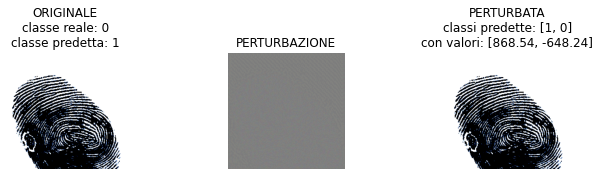

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMMAGINE  1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


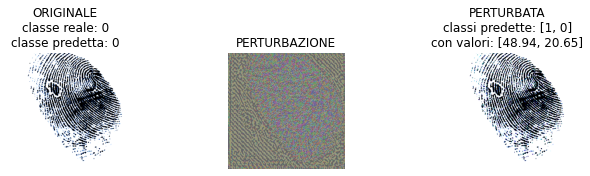

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMMAGINE  2


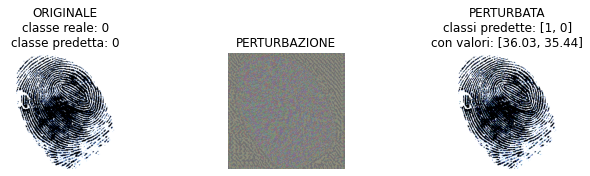

IMMAGINE  3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


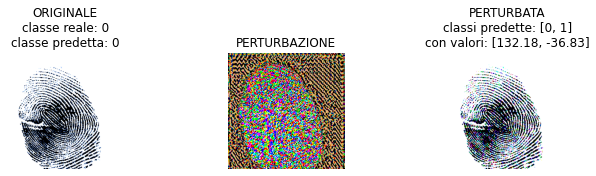

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMMAGINE  4


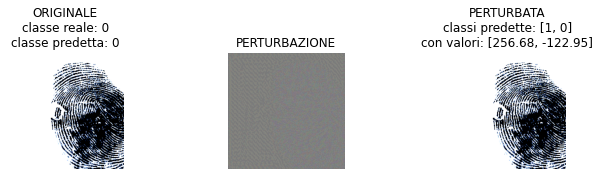

IMMAGINE  5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


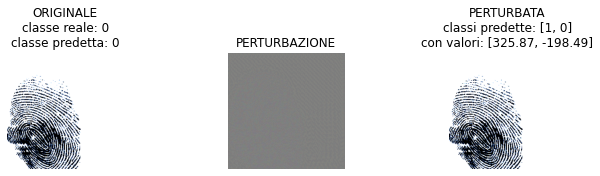

IMMAGINE  6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


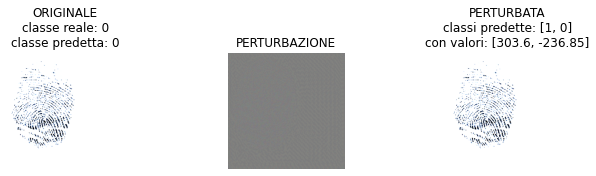

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMMAGINE  7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


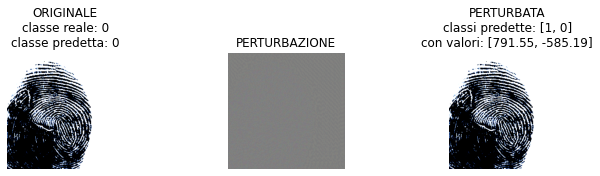

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMMAGINE  8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


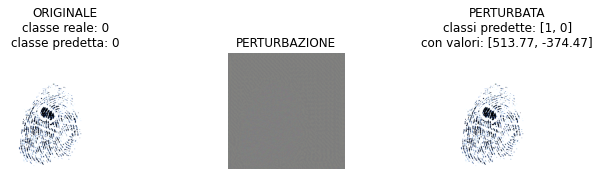

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMMAGINE  9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


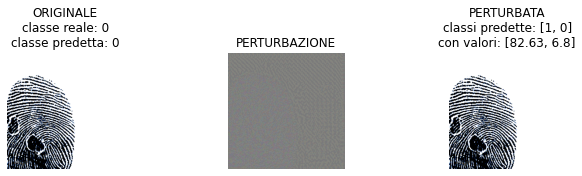

In [63]:
print_subplot(10,preds,value_preds_adv,x_test,y_test,x_test_adv,perturb_norm)